# Pol2_list: from survey to HPO 

In [ ]:
import pandas as pd
import requests

In [ ]:
# Your CSV file path
csv_file_path = "2result.xlsx"
# Read CSV, skip the first row, and select only the desired columns
df = pd.read_excel(csv_file_path)
# Prepare empty columns for results
print(df.head())

  field_type                                           question  true_term  \
0      radio  Breathing support Has this individual ever req...        NaN   
1      radio  Strabismus Has your child been diagnosed with ...        NaN   
2      radio                 Mchat 13 13. Does your child walk?        NaN   
3      radio  Mchat 14 14. Does your child look you in the e...        NaN   
4      radio  Palmar hyperkeratosis Do you have palmar hyper...        NaN   

    true_code  true_CUI             agent_term  agent_code agent_CUI  \
0  HP:0002098  C0476273   Respiratory distress  HP:0002098  C0476273   
1  HP:0000486  C0038379             Strabismus  HP:0000486  C0038379   
2  HP:0002540  C0560046        Delayed walking  HP:0002540  C0560046   
3  HP:0000817  C1445953       Poor eye contact  HP:0000817  C1445953   
4  HP:0010765  C4023710  Palmar hyperkeratosis  HP:0010765  C4023710   

   agent_Wu  agent_LLM_Score  ...             BERT_code.1  \
0       1.0              NaN  ...    

In [ ]:
# Use a data to test before officially starting the running
from experiments.builder_without_validate_node import umls_mapping_graph

result = umls_mapping_graph.invoke(
    {"text": "Palmar hyperkeratosis", "field_type": "radio"}
)
print(result)

✅ Extracted terms: ['Palmar hyperkeratosis']
🌐 [Palmar hyperkeratosis] API Status: 200
✅ Results for Palmar hyperkeratosis: [{'code': 'HP:0010765', 'term': 'Palmar hyperkeratosis', 'description': 'Abnormal thickening of the skin localized to the palm of the hand. [https://orcid.org/0000-0002-0736-9199]'}, {'code': 'HP:0007508', 'term': 'Punctate palmar hyperkeratosis', 'description': 'Tiny bumps of thickened skin (hyperkeratosis) on the palms of the hands. []'}]
🧪 Final UMLS mappings: [{'original': 'Palmar hyperkeratosis', 'candidates': [{'code': 'HP:0010765', 'term': 'Palmar hyperkeratosis', 'description': 'Abnormal thickening of the skin localized to the palm of the hand. [https://orcid.org/0000-0002-0736-9199]'}, {'code': 'HP:0007508', 'term': 'Punctate palmar hyperkeratosis', 'description': 'Tiny bumps of thickened skin (hyperkeratosis) on the palms of the hands. []'}]}]
🧩 Entered rank_mappings_node
🧠 Raw LLM output for 'Palmar hyperkeratosis': [
  {
    "matched_code": "HP:0010765

In [ ]:
for idx, row in df.iterrows():
    question_text = row["question"]
    field_type = row["field_type"]

    best_match_code = ""
    best_match_term = ""
    confidence = 0.0

    try:
        result = umls_mapping_graph.invoke(
            {
                "text": question_text,
                "field_type": field_type,
                "retries": 0,  # 固定为 0
            }
        )

        # 优先检查 refine_mapping
        refine_mapping = result.get("refine_mapping", {})
        if refine_mapping and isinstance(refine_mapping, dict):
            best_match_code = refine_mapping.get("refined_code", "")
            best_match_term = refine_mapping.get("refined_term", "")
            confidence = 1.0  # refined 视为高置信度
        else:
            # 回退检查 validated_mappings
            validated_mappings = result.get("validated_mappings", [])
            if validated_mappings and isinstance(validated_mappings, list):
                best_mapping = validated_mappings[0]
                best_match_code = best_mapping.get("best_match_code", "")
                best_match_term = best_mapping.get("best_match_term", "")
                confidence = best_mapping.get("confidence", 0.0)

                if isinstance(confidence, str):
                    try:
                        confidence = float(confidence)
                    except ValueError:
                        confidence = 0.0

    except Exception as e:
        print(f"❌ Error on row {idx + 1}: {e}")

    # 写入 DataFrame
    df.at[idx, "without_retry_code"] = best_match_code
    df.at[idx, "without_retry_term"] = best_match_term
    df.at[idx, "without_retry_confidence"] = confidence

    print(f"✅ Processed row {idx + 1}")


✅ Extracted terms: ['Respiratory distress']
🌐 [Respiratory distress] API Status: 200
✅ Results for Respiratory distress: [{'code': 'HP:0033677', 'term': 'Acute respiratory distress syndrome', 'description': "Acute respiratory distress syndrome (ARDS) is defined as an acute disorder that starts within seven days of the inciting event and is characterized by bilateral lung infiltrates and severe progressive hypoxemia in the absence of any evidence of cardiogenic pulmonary edema. ARDS is defined by the patient's oxygen in arterial blood (PaO2) to the fraction of the oxygen in the inspired air (FiO2). These patients have a PaO2/FiO2 ratio of less than 300. [PMID:28613773]"}, {'code': 'HP:0004885', 'term': 'Episodic respiratory distress', 'description': None}, {'code': 'HP:0002643', 'term': 'Infantile respiratory distress', 'description': 'Respiratory difficulty as newborn. [https://orcid.org/0000-0002-0736-9199]'}, {'code': 'HP:0002098', 'term': 'Respiratory distress', 'description': 'Resp

In [35]:
df.to_excel("ML4H_nodes_test_1.xlsx", index=False)

In [ ]:
from experiments.builder_without_rank_node import umls_mapping_graph

for idx, row in df.iterrows():
    question_text = row["question"]
    field_type = row["field_type"]

    best_match_code = ""
    best_match_term = ""
    confidence = 0.0

    try:
        result = umls_mapping_graph.invoke(
            {
                "text": question_text,
                "field_type": field_type,
                "retries": 0,  # 固定为 0
            }
        )

        # 优先检查 refine_mapping
        refine_mapping = result.get("refine_mapping", {})
        if refine_mapping and isinstance(refine_mapping, dict):
            best_match_code = refine_mapping.get("refined_code", "")
            best_match_term = refine_mapping.get("refined_term", "")
            confidence = 1.0  # refined 视为高置信度
        else:
            # 回退检查 validated_mappings
            validated_mappings = result.get("validated_mappings", [])
            if validated_mappings and isinstance(validated_mappings, list):
                best_mapping = validated_mappings[0]
                best_match_code = best_mapping.get("best_match_code", "")
                best_match_term = best_mapping.get("best_match_term", "")
                confidence = best_mapping.get("confidence", 0.0)

                if isinstance(confidence, str):
                    try:
                        confidence = float(confidence)
                    except ValueError:
                        confidence = 0.0

    except Exception as e:
        print(f"❌ Error on row {idx + 1}: {e}")

    # 写入 DataFrame
    df.at[idx, "without_rank_code"] = best_match_code
    df.at[idx, "without_rank_term"] = best_match_term
    df.at[idx, "without_rank_confidence"] = confidence

    print(f"✅ Processed row {idx + 1}")

✅ Extracted terms: ['Respiratory distress']
🌐 [Respiratory distress] API Status: 200
✅ Results for Respiratory distress: [{'code': 'HP:0033677', 'term': 'Acute respiratory distress syndrome', 'description': "Acute respiratory distress syndrome (ARDS) is defined as an acute disorder that starts within seven days of the inciting event and is characterized by bilateral lung infiltrates and severe progressive hypoxemia in the absence of any evidence of cardiogenic pulmonary edema. ARDS is defined by the patient's oxygen in arterial blood (PaO2) to the fraction of the oxygen in the inspired air (FiO2). These patients have a PaO2/FiO2 ratio of less than 300. [PMID:28613773]"}, {'code': 'HP:0004885', 'term': 'Episodic respiratory distress', 'description': None}, {'code': 'HP:0002643', 'term': 'Infantile respiratory distress', 'description': 'Respiratory difficulty as newborn. [https://orcid.org/0000-0002-0736-9199]'}, {'code': 'HP:0002098', 'term': 'Respiratory distress', 'description': 'Resp

In [ ]:
from experiments.builder_without_validate_node import umls_mapping_graph

for idx, row in df.iterrows():
    question_text = row["question"]
    field_type = row["field_type"]

    best_match_code = ""
    best_match_term = ""
    confidence = 0.0

    try:
        result = umls_mapping_graph.invoke(
            {
                "text": question_text,
                "field_type": field_type,
                "retries": 0,  # 固定为 0
            }
        )

        # 优先检查 refine_mapping
        refine_mapping = result.get("refine_mapping", {})
        if refine_mapping and isinstance(refine_mapping, dict):
            best_match_code = refine_mapping.get("refined_code", "")
            best_match_term = refine_mapping.get("refined_term", "")
            confidence = 1.0  # refined 视为高置信度
        else:
            # 回退检查 validated_mappings
            validated_mappings = result.get("validated_mappings", [])
            if validated_mappings and isinstance(validated_mappings, list):
                best_mapping = validated_mappings[0]
                best_match_code = best_mapping.get("best_match_code", "")
                best_match_term = best_mapping.get("best_match_term", "")
                confidence = best_mapping.get("confidence", 0.0)

                if isinstance(confidence, str):
                    try:
                        confidence = float(confidence)
                    except ValueError:
                        confidence = 0.0

    except Exception as e:
        print(f"❌ Error on row {idx + 1}: {e}")

    # 写入 DataFrame
    df.at[idx, "without_validate_code"] = best_match_code
    df.at[idx, "without_validate_term"] = best_match_term
    df.at[idx, "without_validate_confidence"] = confidence

    print(f"✅ Processed row {idx + 1}")

✅ Extracted terms: ['Respiratory distress']
🌐 [Respiratory distress] API Status: 200
✅ Results for Respiratory distress: [{'code': 'HP:0033677', 'term': 'Acute respiratory distress syndrome', 'description': "Acute respiratory distress syndrome (ARDS) is defined as an acute disorder that starts within seven days of the inciting event and is characterized by bilateral lung infiltrates and severe progressive hypoxemia in the absence of any evidence of cardiogenic pulmonary edema. ARDS is defined by the patient's oxygen in arterial blood (PaO2) to the fraction of the oxygen in the inspired air (FiO2). These patients have a PaO2/FiO2 ratio of less than 300. [PMID:28613773]"}, {'code': 'HP:0004885', 'term': 'Episodic respiratory distress', 'description': None}, {'code': 'HP:0002643', 'term': 'Infantile respiratory distress', 'description': 'Respiratory difficulty as newborn. [https://orcid.org/0000-0002-0736-9199]'}, {'code': 'HP:0002098', 'term': 'Respiratory distress', 'description': 'Resp

In [ ]:
df.to_excel("ML4H_nodes_test.xlsx", index=False)

# Get more data for model performance evaluation

1.Get CUI code data through ‘term’

In [ ]:
import pandas as pd

excel_file_path = "ML4H_nodes_test.xlsx"
# Read CSV, skip the first row, and select only the desired columns
df = pd.read_excel(excel_file_path)
# Prepare empty columns for results
print(df.head())

  field_type                                           question  true_term  \
0      radio  Breathing support Has this individual ever req...        NaN   
1      radio  Strabismus Has your child been diagnosed with ...        NaN   
2      radio                 Mchat 13 13. Does your child walk?        NaN   
3      radio  Mchat 14 14. Does your child look you in the e...        NaN   
4      radio  Palmar hyperkeratosis Do you have palmar hyper...        NaN   

    true_code  true_CUI             agent_term  agent_code agent_CUI  \
0  HP:0002098  C0476273   Respiratory distress  HP:0002098  C0476273   
1  HP:0000486  C0038379             Strabismus  HP:0000486  C0038379   
2  HP:0002540  C0560046        Delayed walking  HP:0002540  C0560046   
3  HP:0000817  C1445953       Poor eye contact  HP:0000817  C1445953   
4  HP:0010765  C4023710  Palmar hyperkeratosis  HP:0010765  C4023710   

   agent_Wu  agent_LLM_Score  ...     without_retry_term without_retry_CUI  \
0       1.0         

In [ ]:
API_BASE_URL = "http://localhost:8000"


# Using extracted terms to search CUI
def search_cui(term):
    """Search for CUIs using the API."""
    response = requests.get(f"{API_BASE_URL}/cuis", params={"query": term})
    return response.json()


# Defined CUI extraction function and extracts the first CUI returned
def get_cui_from_ontology(hpo_code):
    """Get CUI from a specific ontology term."""
    response = requests.get(f"{API_BASE_URL}/hpo_to_cui/{hpo_code}")
    print(f"Response content for HPO code {hpo_code}:", response.text)
    try:
        return response.json()["cui"]
    except KeyError:
        print("Key 'cui' not found in response.")
        return None  # or raise an error/log as needed


In [ ]:
# Run the code
for idx, row in df.iterrows():
    without_retry_code = row["without_retry_code"]
    true_code = row["true_code"]
    true_CUI = row["true_CUI"]
    # Get Predicted_CUI
    if without_retry_code == true_code:
        # If hpo_code = predicted hpo_code，then True_CUI = Predicted CUI
        df.at[idx, "without_retry_CUI"] = true_CUI
    else:
        without_retry_CUI = get_cui_from_ontology(without_retry_code)
        df.at[idx, "without_retry_CUI"] = without_retry_CUI

# Check the results
print(df[["true_CUI", "without_retry_CUI"]].head())

/var/folders/nb/4qmmwm7j43x3py5_nzg7b6w40000gn/T/ipykernel_66732/3831633604.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'C0476273' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'without_retry_CUI'] = true_CUI


Response content for HPO code HP:0000483: {"hpo_code":"HP:0000483","cui":"C0004106"}
Response content for HPO code nan: {"detail":"404: CUI not found for the given HPO code"}
Key 'cui' not found in response.
Response content for HPO code nan: {"detail":"404: CUI not found for the given HPO code"}
Key 'cui' not found in response.
Response content for HPO code HP:0010780: {"hpo_code":"HP:0010780","cui":"C0034880"}
Response content for HPO code nan: {"detail":"404: CUI not found for the given HPO code"}
Key 'cui' not found in response.
Response content for HPO code HP:0001290: {"hpo_code":"HP:0001290","cui":"C1858120"}
Response content for HPO code HP:0001290: {"hpo_code":"HP:0001290","cui":"C1858120"}
Response content for HPO code HP:0002194: {"hpo_code":"HP:0002194","cui":"C1837658"}
Response content for HPO code HP:0010536: {"hpo_code":"HP:0010536","cui":"C0520680"}
Response content for HPO code HP:0008929: {"hpo_code":"HP:0008929","cui":"C4024614"}
Response content for HPO code HP:003

In [ ]:
# Run the code
for idx, row in df.iterrows():
    without_rank_code = row["without_rank_code"]
    true_code = row["true_code"]
    true_CUI = row["true_CUI"]
    # Get Predicted_CUI
    if without_rank_code == true_code:
        # If hpo_code = predicted hpo_code，then True_CUI = Predicted CUI
        df.at[idx, "without_rank_CUI"] = true_CUI
    else:
        without_rank_CUI = get_cui_from_ontology(without_rank_code)
        df.at[idx, "without_rank_CUI"] = without_rank_CUI

# Check the results
print(df[["true_CUI", "without_rank_CUI"]].head())

Response content for HPO code HP:0033677: {"hpo_code":"HP:0033677","cui":"C2887484"}
Response content for HPO code HP:0031717: {"hpo_code":"HP:0031717","cui":"C0152207"}


/var/folders/nb/4qmmwm7j43x3py5_nzg7b6w40000gn/T/ipykernel_66732/935498382.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'C2887484' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'without_rank_CUI'] = without_rank_CUI


Response content for HPO code HP:0031936: {"hpo_code":"HP:0031936","cui":"C0241726"}
Response content for HPO code HP:0011451: {"hpo_code":"HP:0011451","cui":"C2677180"}
Response content for HPO code HP:0008755: {"hpo_code":"HP:0008755","cui":"C0585984"}
Response content for HPO code HP:0008222: {"hpo_code":"HP:0008222","cui":"C0021361"}
Response content for HPO code HP:0010780: {"hpo_code":"HP:0010780","cui":"C0034880"}
Response content for HPO code HP:0012389: {"hpo_code":"HP:0012389","cui":"C4022919"}
Response content for HPO code HP:0010926: {"hpo_code":"HP:0010926","cui":"C1861832"}
Response content for HPO code HP:0100852: {"hpo_code":"HP:0100852","cui":"C4018849"}
Response content for HPO code HP:0005338: {"hpo_code":"HP:0005338","cui":"C1857206"}
Response content for HPO code HP:0012389: {"hpo_code":"HP:0012389","cui":"C4022919"}
Response content for HPO code HP:0002194: {"hpo_code":"HP:0002194","cui":"C1837658"}
Response content for HPO code HP:0006564: {"hpo_code":"HP:0006564

In [ ]:
# Run the code
for idx, row in df.iterrows():
    without_validate_code = row["without_validate_code"]
    true_code = row["true_code"]
    true_CUI = row["true_CUI"]
    # Get Predicted_CUI
    if without_validate_code == true_code:
        # If hpo_code = predicted hpo_code，then True_CUI = Predicted CUI
        df.at[idx, "without_validate_CUI"] = true_CUI
    else:
        without_validate_CUI = get_cui_from_ontology(without_validate_code)
        df.at[idx, "without_validate_CUI"] = without_validate_CUI

# Check the results
print(df[["true_CUI", "without_validate_CUI"]].head())

/var/folders/nb/4qmmwm7j43x3py5_nzg7b6w40000gn/T/ipykernel_66732/3139148217.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'C0476273' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'without_validate_CUI'] = true_CUI


Response content for HPO code HP:0031717: {"hpo_code":"HP:0031717","cui":"C0152207"}
Response content for HPO code HP:0001518: {"hpo_code":"HP:0001518","cui":"C0235991"}
Response content for HPO code HP:0010780: {"hpo_code":"HP:0010780","cui":"C0034880"}
Response content for HPO code HP:0001290: {"hpo_code":"HP:0001290","cui":"C1858120"}
Response content for HPO code HP:0011141: {"hpo_code":"HP:0011141","cui":"C0036646"}
Response content for HPO code HP:0001290: {"hpo_code":"HP:0001290","cui":"C1858120"}
Response content for HPO code HP:0002194: {"hpo_code":"HP:0002194","cui":"C1837658"}
Response content for HPO code HP:0010536: {"hpo_code":"HP:0010536","cui":"C0520680"}
Response content for HPO code HP:0008929: {"hpo_code":"HP:0008929","cui":"C4024614"}
Response content for HPO code HP:0034435: {"hpo_code":"HP:0034435","cui":"C5775214"}
Response content for HPO code HP:0012760: {"hpo_code":"HP:0012760","cui":"C4022736"}
Response content for HPO code HP:0012760: {"hpo_code":"HP:0012760

In [36]:
df.head()

,field_type,question,true_term,true_code,true_CUI,agent_term,agent_code,agent_CUI,agent_Wu,agent_LLM_Score,...,without_retry_term,without_retry_CUI,without_retry_confidence,without_rank_code,without_rank_term,without_rank_CUI,without_rank_confidence,without_validate_code,without_validate_term,without_validate_CUI
0,radio,Breathing support Has this individual ever req...,NaN,HP:0002098,C0476273,Respiratory distress,HP:0002098,C0476273,1.0,NaN,...,Respiratory distress,C0476273,0.7,HP:0033677,NaN,C2887484,0,HP:0002098,NaN,C0476273
1,radio,Strabismus Has your child been diagnosed with ...,NaN,HP:0000486,C0038379,Strabismus,HP:0000486,C0038379,1.0,NaN,...,Strabismus,C0004106,1.0,HP:0031717,Delayed walking,C0152207,0,HP:0031717,NaN,C0152207
2,radio,Mchat 13 13. Does your child walk?,NaN,HP:0002540,C0560046,Delayed walking,HP:0002540,C0560046,1.0,NaN,...,NaN,None,0.0,HP:0031936,NaN,C0241726,0,HP:0002540,NaN,C0560046
3,radio,Mchat 14 14. Does your child look you in the e...,NaN,HP:0000817,C1445953,Poor eye contact,HP:0000817,C1445953,1.0,NaN,...,Poor eye contact,C1445953,0.9,HP:0000817,NaN,C1445953,0,HP:0000817,NaN,C1445953
4,radio,Palmar hyperkeratosis Do you have palmar hyper...,NaN,HP:0010765,C4023710,Palmar hyperkeratosis,HP:0010765,C4023710,1.0,NaN,...,Palmar hyperkeratosis,C4023710,1.0,HP:0010765,NaN,C4023710,0,HP:0010765,NaN,C4023710


In [ ]:
# 2. Define the model and corresponding column names
model_columns = {
    "without_retry_node": "without_retry_CUI",
    "without_rank_node": "without_rank_CUI",
    "without_validate_node": "without_validate_CUI",
    "GenOMA": "agent_CUI",
}

In [ ]:
import pandas as pd

# Canonical null representation
df["true_CUI"] = df["true_CUI"].fillna("None").astype(str).str.strip()

results = {}


def safe_div(n, d):
    return n / d if d > 0 else 0.0


for model_name, pred_col in model_columns.items():
    if pred_col not in df.columns:
        print(f"Column '{pred_col}' not found, skipping {model_name}")
        continue

    df[pred_col] = df[pred_col].fillna("None").astype(str).str.strip()
    y_true = df["true_CUI"]
    y_pred = df[pred_col]

    # TP: correct code when gold exists
    tp = ((y_pred == y_true) & (y_true != "None")).sum()

    # FP: (1) wrong code when gold exists OR (2) any code when gold is empty
    fp_wrong_when_gold = (
        (y_true != "None") & (y_pred != "None") & (y_pred != y_true)
    ).sum()
    fp_pred_when_empty = ((y_true == "None") & (y_pred != "None")).sum()
    fp = fp_wrong_when_gold + fp_pred_when_empty

    # FN: predicted nothing when gold exists
    fn = ((y_pred == "None") & (y_true != "None")).sum()

    # TNs are excluded from headline metrics by design
    # tn = ((y_true == 'None') & (y_pred == 'None')).sum()  # not used

    precision = safe_div(tp, tp + fp)
    recall = safe_div(tp, tp + fn)
    f1 = safe_div(2 * precision * recall, (precision + recall))

    # Mapping accuracy (positives-only): excludes TNs
    mapping_accuracy = safe_div(tp, tp + fp + fn)

    results[model_name] = {
        "tp": int(tp),
        "fp": int(fp),
        "fn": int(fn),
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1": round(f1, 4),
        "mapping_accuracy": round(mapping_accuracy, 4),
    }

results_df = pd.DataFrame(results).T
print(results_df)

                          tp    fp    fn  precision  recall      f1  \
without_retry_node      79.0  22.0  18.0     0.7822  0.8144  0.7980   
without_rank_node       67.0  49.0   3.0     0.5776  0.9571  0.7204   
without_validate_node   83.0  33.0   3.0     0.7155  0.9651  0.8218   
GenOMA                 109.0   7.0   3.0     0.9397  0.9732  0.9561   

                       mapping_accuracy  
without_retry_node               0.6639  
without_rank_node                0.5630  
without_validate_node            0.6975  
GenOMA                           0.9160  


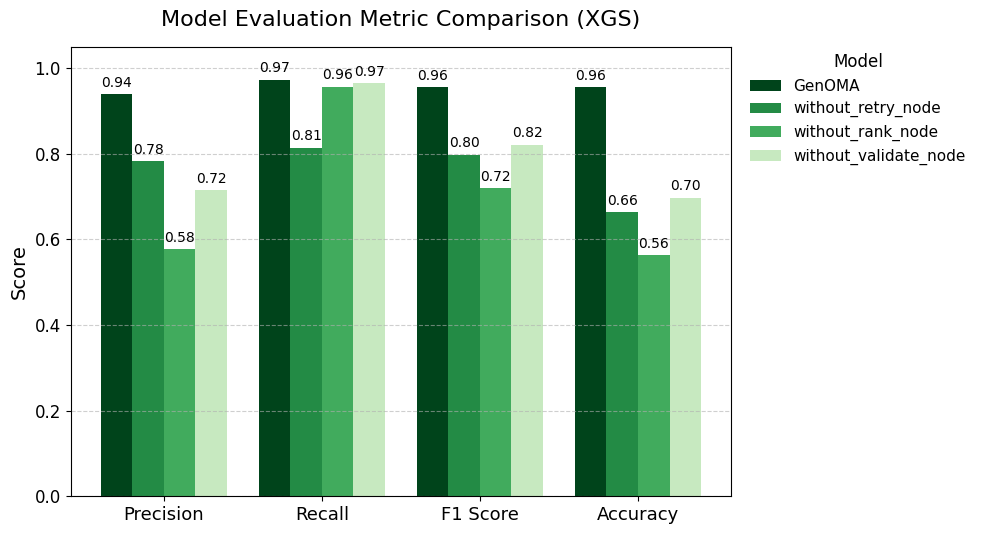

In [ ]:
# Model and performance data
models = ["GenOMA", "without_retry_node", "without_rank_node", "without_validate_node"]
precision = [0.9397, 0.7822, 0.5776, 0.7155]
recall = [0.9732, 0.8144, 0.9571, 0.9651]
f1 = [0.9561, 0.7980, 0.7204, 0.8218]
accuracy = [0.9561, 0.6639, 0.5630, 0.6975]

# Indicator name
metrics = ["Precision", "Recall", "F1 Score", "Accuracy"]
metric_values = [precision, recall, f1, accuracy]

# Coordinate settings
x = np.arange(len(metrics))  # [0, 1, 2]
bar_width = 0.2

# Professional color palette: 4 yellow-green transition colors from dark to light
colors = ["#00441b", "#238b45", "#41ab5d", "#c7e9c0"]

# Set the image style
fig, ax = plt.subplots(figsize=(10, 5.5))
plt.rcParams.update({"font.size": 12})

# Draw the columns for each model
for i, model in enumerate(models):
    values = [metric[i] for metric in metric_values]
    bars = ax.bar(x + i * bar_width, values, bar_width, label=model, color=colors[i])

    # Add labels inside columns
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.2f}",
            xy=(bar.get_x() + bar.get_width() / 2, height + 0.01),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
        )

# Set up axes and titles
ax.set_ylabel("Score", fontsize=14)
ax.set_title("Model Evaluation Metric Comparison (XGS)", fontsize=16, pad=15)
ax.set_xticks(x + 1.5 * bar_width)
ax.set_xticklabels(metrics, fontsize=13)
ax.set_ylim(0, 1.05)
ax.yaxis.grid(True, linestyle="--", alpha=0.6)

# Setting the Legend
ax.legend(
    title="Model",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    fontsize=11,
    title_fontsize=12,
    frameon=False,
)

plt.tight_layout()
plt.savefig("6.pdf", format="pdf", bbox_inches="tight")
plt.show()
